loaded model from disk
False Positive Rate:
[ 0.       0.       0.      ...,  0.99312  0.99984  1.     ]
True Positive Rate:
[  8.00000000e-05   7.68000000e-03   7.84000000e-03 ...,   1.00000000e+00
   1.00000000e+00   1.00000000e+00]
Threshold:
[  9.99979734e-01   9.99009311e-01   9.99000609e-01 ...,   3.82931903e-03
   2.88854179e-04   3.07300215e-05]
roc_auc_score:
0.945669488


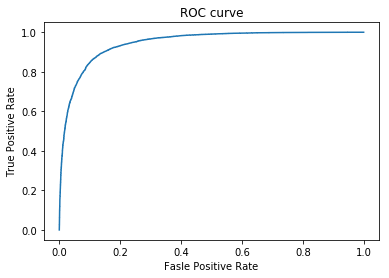

In [30]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score
import os
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import model_from_json
from keras.optimizers import rmsprop
# load the model
from keras.engine.topology import Layer, InputSpec
from keras import backend as K
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn. metrics import roc_curve

import pickle

CONTEXT_DIM = 100

class AttLayer(Layer):
    def __init__(self, regularizer=None, **kwargs):
        self.regularizer = regularizer
        self.supports_masking = True
        super(AttLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(name='W', shape=(input_shape[-1], CONTEXT_DIM), initializer='normal', trainable=True,
                                 regularizer=self.regularizer)
        self.b = self.add_weight(name='b', shape=(CONTEXT_DIM,), initializer='normal', trainable=True,
                                 regularizer=self.regularizer)
        self.u = self.add_weight(name='u', shape=(CONTEXT_DIM,), initializer='normal', trainable=True,
                                 regularizer=self.regularizer)
        super(AttLayer, self).build(input_shape)  # be sure you call this somewhere!

    def call(self, x, mask=None):
        eij = K.dot(K.tanh(K.dot(x, self.W) + self.b), self.u)
        ai = K.exp(eij)
        alphas = ai / K.sum(ai, axis=1).dimshuffle(0, 'x')
        if mask is not None:
            # use only the inputs specified by the mask
            alphas *= mask
        weighted_input = x * alphas.dimshuffle(0, 1, 'x')
        return weighted_input.sum(axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = {}
        base_config = super(AttLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_mask(self, inputs, mask):
        return None


def load_HAN(json, h5):

    json_file = open(json, 'r')

    loaded_model_json = json_file.read()
    json_file.close()

    loaded_model = model_from_json(loaded_model_json, custom_objects={'AttLayer': AttLayer()})

    # load_weight
    loaded_model.load_weights(h5)

    print("loaded model from disk")

    optimizer1 = rmsprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    loaded_model.compile(loss='categorical_crossentropy', optimizer=optimizer1, metrics=['acc'])

    return loaded_model


def get_MSE(y_true,y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    return MSE

def get_Precision(y_pred1,y_true1):
    y_pred = np.argmax(y_pred1,axis=1)
    y_true = np.argmax(y_true1,axis=1)
    precision = precision_score(y_true=y_true, y_pred=y_pred)

    return precision

def get_Recall(y_true, y_pred):
    recall = recall_score(y_true= y_true, y_pred=y_pred)
    return recall


def get_F1_Score(y_true, y_pred):
    F1_score = f1_score(y_true=y_true, y_pred=y_pred)

    return F1_score


def ROC_AUC_chart(y_preds):

    #get the test_labels
    f1 = open('y_test_labels', 'rb')
    test_labels = pickle.load(f1)
    #test_lables1 = np.argmax(test_labels, axis = 1)
   # print(test_lables1)
    fpr, tpr, threshold= roc_curve(test_labels[:,1], y_preds[:,1])
    print("False Positive Rate:")
    print(fpr)
    print("True Positive Rate:")
    print(tpr)
    print("Threshold:")
    print(threshold)
    
    plt.plot(fpr,tpr,label='HAN Classifier')
    plt.xlabel("Fasle Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('ROC curve')
    print("roc_auc_score:")
    print(roc_auc_score(test_labels[:,1], y_preds[:,1]))

def get_all_metrics(y_true, y_pred):

    MSE  = get_MSE(y_true=y_true,y_pred=y_true)
    precision = get_Precision(y_pred1=y_pred,y_true1=y_true)
    recall = get_Recall(y_true=y_true,y_pred=y_pred)
    F1_Score = get_F1_Score(y_true=y_true, y_pred=y_pred)

    ROC_AUC_chart(y_pred)


#--------main-----------------------------------

JSON_file= "/Users/xiaoyiwen/Desktop/MasterProject/MasterProject/data_Preprocessing/HAN_Classifier/HAN_Model/HAN1_rmsprop_L20.002_15.json"
h5_file = "/Users/xiaoyiwen/Desktop/MasterProject/MasterProject/data_Preprocessing/HAN_Classifier/HAN_Model/HAN1_rmsprop_L20.02_15.h5"


model = load_HAN(json=JSON_file, h5=h5_file)

f1 = open('2_y_pred_file','rb')
y_preds = pickle.load(f1)

ROC_AUC_chart(y_preds = y_preds)

